# In this lab, we will use PCA to "recreate" similar facial structures

- With the rise in facial recognition and image recognition, this material is especially timely

In [1]:
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
import numpy as np
%matplotlib inline

In [2]:
# setup the data
n_row, n_col = 3, 3
n_pictures = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

In [3]:
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering - we do this to balance all of the faces across rows
# think of centering as "stabilizing" the pixels
faces_centered = faces - faces.mean(axis=0)

# local centering - we do this to balance all of the faces across columns
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of {} faces").format(n_samples)

Dataset consists of 400 faces


# Make sure we understand pixels

Assume pixels are on a range of [0,255]

This represents [8 bit color](https://en.wikipedia.org/wiki/8-bit_color)

We will only use grayscale for today to make the example easier to understand and use.

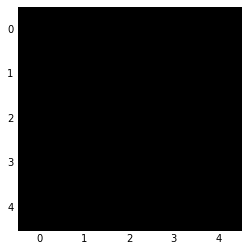

In [4]:
plt.imshow(np.ones((5,5))*0, cmap=plt.cm.gray, vmin=0, vmax=255)

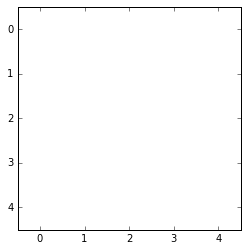

In [5]:
plt.imshow(np.ones((5,5))*255, cmap=plt.cm.gray, vmin=0, vmax=255)

What's happening in the 2 examples above? What changed? Why?

Multiplying by 0 is like the "absence" of color. We are blacking out each of the pixels. 

# Creating our face plots

In [6]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

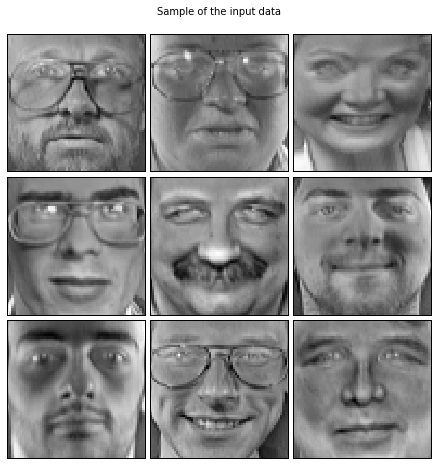

In [7]:
plot_gallery("Sample of the input data", faces_centered[:n_pictures], 3, 3)

# Now we will use PCA to "recreate" the faces

- This can be thought of as a form of image similarity
- Similar to tools used in Photoshop (I believe it's the lasso tool, but don't quote me on that)
- Many applications in crime, biology, pattern recognition

In [8]:
faces_centered

array([[ 0.27765974,  0.21050064,  0.1808518 , ..., -0.22626604,
        -0.22262967, -0.22770201],
       [ 0.41331112,  0.36681321,  0.31237099, ...,  0.20690602,
         0.35930276,  0.38728827],
       [ 0.0167652 , -0.0421294 , -0.06351379, ...,  0.43019482,
         0.41317004,  0.28413075],
       ..., 
       [ 0.12508598,  0.13643926,  0.14811277, ..., -0.17636046,
        -0.13966623, -0.1488708 ],
       [ 0.08992872,  0.0558275 ,  0.02617866, ...,  0.11492857,
         0.09377155,  0.09696367],
       [-0.06032472, -0.12335157, -0.19019049, ..., -0.00639924,
        -0.10193643, -0.06981868]], dtype=float32)

In [9]:
faces_centered.shape

(400, 4096)

# Why 4096 features/columns?

Read the documentation for the dataset [here](http://scikit-learn.org/stable/datasets/olivetti_faces.html)

Answer: the images are 64x64, so each feature represents a single pixel

# Do we need to standardize features?

No, all features are already on the same scale. We can see below since we did centering the mean for each column is about 0.

In [10]:
import numpy as np
print np.mean(faces_centered, axis=0)

[  1.17579475e-07   1.43442307e-07   6.18770741e-08 ...,  -1.88592821e-08
  -1.66893006e-08  -3.47010776e-08]


# Create PCA model

- Let's investigate this whiten parameter

In [11]:
pca = PCA(n_components=9, whiten=True)
pca.fit(faces_centered)
pca2 = PCA(n_components=9, whiten=False)
pca2.fit(faces_centered)

PCA(copy=True, n_components=9, whiten=False)

In [12]:
np.var(pca.components_[0]) == np.var(pca2.components_[0])

True

In [13]:
np.var(pca.components_[0])

0.00024414074

In [14]:
np.var(pca2.components_[0])

0.00024414074

In [15]:
pca.explained_variance_

array([ 11.26593971,   6.31508446,   4.40851164,   3.4729929 ,
         2.52499318,   2.07398081,   1.62184346,   1.60494244,   1.33550465], dtype=float32)

In [16]:
pca2.explained_variance_

array([ 11.26593971,   6.31508446,   4.40851164,   3.4729929 ,
         2.52499318,   2.07398081,   1.62184346,   1.60494244,   1.33550465], dtype=float32)

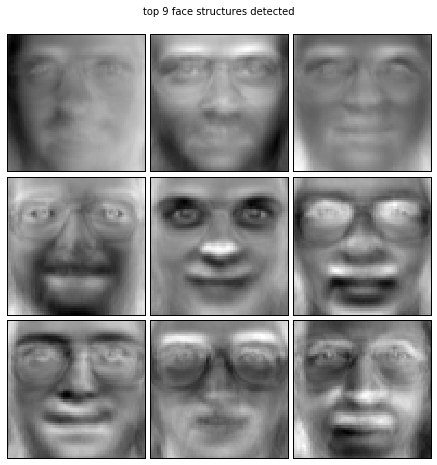

In [17]:
plot_gallery('top 9 face structures detected', pca2.components_[:n_pictures], 3, 3)

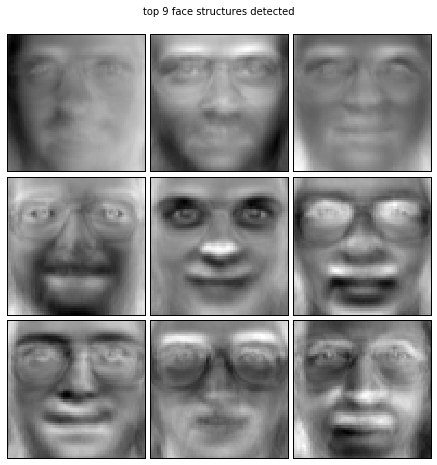

In [18]:
# pay special attention to the last 2 arguments
# their product must equal n_components from pca
plot_gallery('top 9 face structures detected', pca.components_[:n_pictures], 3, 3)

Whitening forces variance of the components to be on the same scale. Whitening is important to use when PCA results are fed to another model downstream, especially a model that requires the features to be standardized. 

- Good parameter to tweak if using PCA as preprocessing before feeding to another model downstream

In [19]:
# each pca component has length 4096
pca.components_[0].shape

(4096,)

# What do each of the components represent?

A reconstruction of faces from the dataset attempting to explain as much variance as possible. Each component can be reconstructed into a "face" picture that is 64x64.

# Examining explained variance

In [20]:
pca.explained_variance_ratio_

array([ 0.18154669,  0.10176539,  0.07104163,  0.05596607,  0.04068939,
        0.03342148,  0.02613544,  0.02586309,  0.02152119], dtype=float32)

Interpret the above line of code in your own words:

This shows the explained variance of each component (picture). The first component is able to explain about 18% of the variance in pictures of faces.

# Choosing n_components

Plot all 400 samples and use the elbow method to determine the amount of n_components. It's okay to eyeball the number.

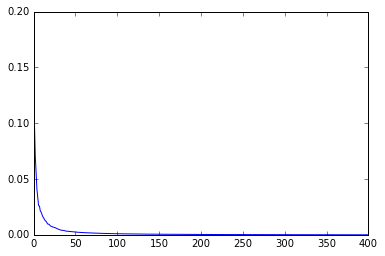

In [21]:
pca = PCA(n_components=400)
pca.fit(faces_centered)
plt.plot(range(n_samples), pca.explained_variance_ratio_)

Let's call it 25 by eyeballing it.

# Plot your top n_components to see what the faces look like

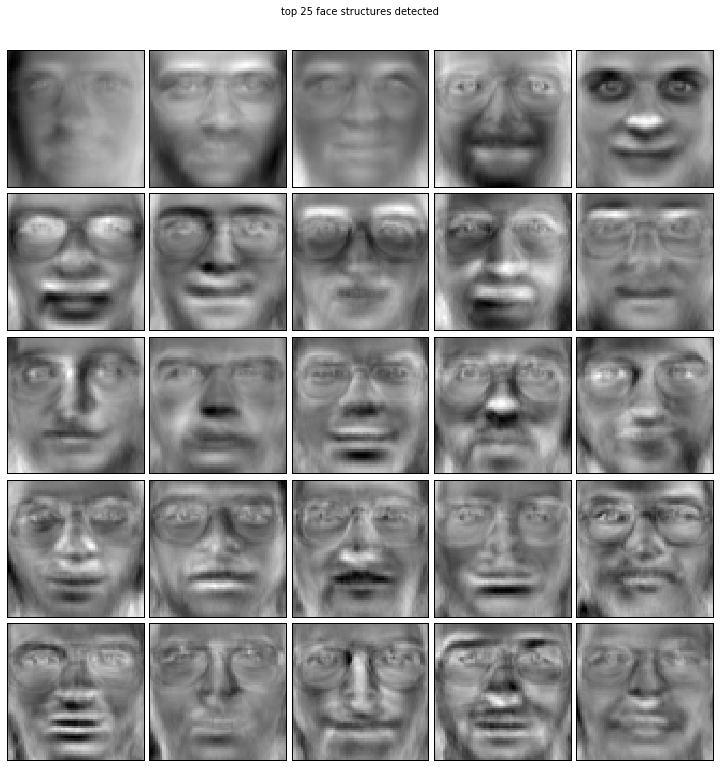

In [23]:
pca = PCA(n_components=25)
pca.fit(faces_centered)
plot_gallery('top 25 face structures detected', pca.components_[:25], 5, 5)

# Take a stab at interpreting the results. What did PCA learn?

Looking at the first few pictures, PCA preferred to learn a nose type and eye type, along with glasses. Perhaps this is where humans show the greatest variation: their nose and eyes.